In [3]:
import os
if '_cwd_set' not in locals(): locals()['_cwd_set'] = os.chdir(os.path.dirname(os.getcwd()))
import omnifig as fig
fig.initialize()
from src.jimports import *
from src.util import set_default_device, repo_root, data_root
device = set_default_device();

Selecting CUDA device 0 with 60120 MiB free memory and 0% utilization


In [2]:
from omniply.apps.training.trainers import TrainerBase
from omnibelt.jester import where_am_i

In [1]:
import os
import clip
import torch
import numpy as np
import requests
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from PIL import Image
from tqdm import tqdm

In [6]:
model, preprocess = clip.load('ViT-L/14', device)

100%|████████████████████████████████████████| 890M/890M [00:09<00:00, 102MiB/s]


In [5]:
text = clip.tokenize(["brown dog on green grass"]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)
text_features.shape

torch.Size([1, 512])

In [5]:
url = 'https://placecats.com/300/200?fit=contain&position=top'
image = preprocess(Image.open(requests.get(url, stream=True).raw)).unsqueeze(0).to(device)
# image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
options = ["a diagram", "a dog", "a cat"]

text = clip.tokenize(options).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.001251 0.010315 0.9883  ]]


In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fd94c3ada80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
image.shape

torch.Size([1, 3, 224, 224])

In [5]:
path = Path('/data/felix/imagenet/')

In [43]:
from torchvision.datasets import ImageNet
from torchvision import datasets, transforms
import json

In [72]:
labels = json.load(path.joinpath('classes.json').open())
# label_lines
val_labels = dict(line.split() for line in path.joinpath('val_label').read_text().splitlines())
val_labels = {k: labels[v] for k,v in val_labels.items()}


1905

In [13]:
valpaths = list(path.glob('val/**/*.JPEG'))
len(valpaths)

50000

In [40]:
num2cat['551']

'ski'

In [75]:
options = [f'A photo of {label}' for label in labels.values()]

text = clip.tokenize(options).to(device)
# with torch.no_grad():
#     text_features = model.encode_text(text)
text.shape, text_features.shape

(torch.Size([1000, 77]), torch.Size([1000, 512]))

matchstick
-----------------------------  ----------
matchstick                     0.873535
hamper                         0.025177
panpipe, pandean pipe, syrinx  0.0225677
carpenter's kit, tool kit      0.0145721
marimba, xylophone             0.00721359
-----------------------------  ----------


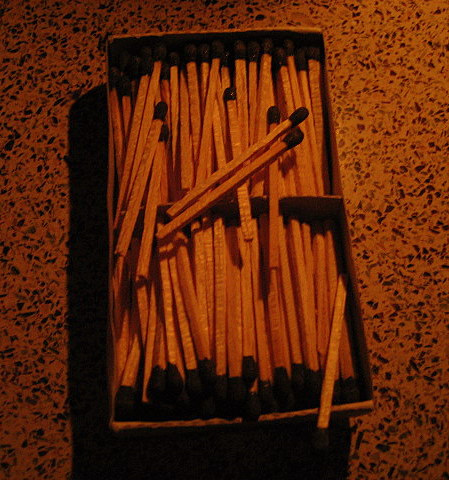

In [124]:
pick = random.choice(valpaths)
print(val_labels[pick.name])
img = Image.open(pick)
with torch.no_grad():
    # image_features = model.encode_image(image)
    image = preprocess(img).unsqueeze(0).to(device)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().tolist()
print(tabulate(Counter(dict(zip(labels.values(), probs[0]))).most_common(5)))
img

In [67]:
print(tabulate(Counter(val_labels.values()).most_common(), headers=['Class', 'Count']))

Class                                                                                                                        Count
-------------------------------------------------------------------------------------------------------------------------  -------
crane                                                                                                                          100
sea snake                                                                                                                       50
alp                                                                                                                             50
Shetland sheepdog, Shetland sheep dog, Shetland                                                                                 50
soup bowl                                                                                                                       50
cradle                                                                             

In [9]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=path / 'val', transform=transform)
len(dataset)

FileNotFoundError: Couldn't find any class folder in /data/felix/imagenet/val.

In [7]:
dataset = ImageNet(path, split='val', )
len(dataset)

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in /data/felix/imagenet.

In [6]:
# Load the dataset
dataroot = data_root() 
train = CIFAR100(dataroot, download=True, train=True, transform=preprocess)
test = CIFAR100(dataroot, download=True, train=False, transform=preprocess)

100%|██████████| 169001437/169001437 [06:27<00:00, 436341.36it/s] 


Extracting /data/felix/project/cifar-100-python.tar.gz to /data/felix/project
Files already downloaded and verified


In [ ]:
def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()


In [ ]:



# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")